# Tensorflow Chessbot Learning Notebook

In this notebook we'll train a tensorflow neural network to tell what piece is on a chess square.
In the previous notebook we wrote scripts that parsed input images which contained a chessboard into 32x32 grayscale chess squares.

In [1]:
# Init and helper functions
import helper_functions as hf
import tensorflow as tf
import numpy as np
import glob
np.set_printoptions(precision=2, suppress=True)

Let's load the tiles in for the training and test dataset

In [2]:
# All lichess tiles with pieces in starting position
train_paths = np.array(glob.glob("train_tiles_A/*/*.png")) # TODO : (set labels correctly)
test_paths = np.array(glob.glob("test_tiles/tiles_lichess_*/*.png"))

# Training dataset
# Generated by programmatic screenshots of lichess.org/editor/<FEN-string>
print "Loading %d Training tiles" % train_paths.size
train_images, train_labels = hf.loadFENtiles(train_paths) # Load from generated set

# Test dataset, taken from screenshots of the starting position
print "Loading %d Training tiles" % test_paths.size
test_images = hf.loadImages(test_paths)
test_labels = hf.loadLabels(test_paths)

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 5120 Training tiles
On #0/5120 : train_tiles_A/tiles_lichess0003__qBKnkBQr-BNKkqR11-BQRBbqBq-qnrKNpqn-qPbK1bbK-QQrbNRKQ-BRPkbbrr-BPNkQrK1/lichess0003__qBKnkBQr-BNKkqR11-BQRBbqBq-qnrKNpqn-qPbK1bbK-QQrbNRKQ-BRPkbbrr-BPNkQrK1_B6.png
On #1000/5120 : train_tiles_A/tiles_lichess0000__Bk1p1rrb-bN1NnnQp-q1QkrqNr-npPnRbrK-bb1Pnbrq-RKQbPbnN-rRKRPkQk-1RbqpkQR/lichess0000__Bk1p1rrb-bN1NnnQp-q1QkrqNr-npPnRbrK-bb1Pnbrq-RKQbPbnN-rRKRPkQk-1RbqpkQR_G2.png
On #2000/5120 : train_tiles_A/tiles_lichess0000__bBBBKknq-1NqbBbKN-kQknKnKR-QNp1NKQk-nQbNPRNb-1KNnQBPk-brbnbQ1b-krpRpqKQ/lichess0000__bBBBKknq-1NqbBbKN-kQknKnKR-QNp1NKQk-nQbNPRNb-1KNnQBPk-brbnbQ1b-krpRpqKQ_D3.png
On #3000/5120 : train_tiles_A/tiles_lichess0000__kkBKbBrk-nKbqnPKK-N1NKrPBk-BqqqqPBQ-r1RpPBnr-qRQRQ1Br-Qbk11bnr-rQrKkQkp/lichess0000__kkBKbBrk-nKbqnPKK-N1NKrPBk-BqqqqPBQ-r1RpPBnr-qRQRQ1Br-Qbk11bnr-rQrKkQkp_F3.png
On #4000/5120 : train_tiles_A/tiles_lichess0000__qNnb1PkK-kqrqBQbK-RNrppRnk-KKp1pqRp-Kb1QNnr1-QRQkpNPq-RQbNKpR1-RqppkKkB/li

Cool, lets look at a few images in the training set

2923: Piece(B) : Label vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


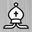

3515: Piece(B) : Label vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


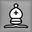

2391: Piece(K) : Label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


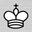

2344: Piece(q) : Label vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


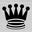

1406: Piece(n) : Label vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


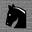

In [3]:
# Visualize a couple tiles
for i in np.random.choice(train_dataset.num_examples, 5):
    print "%d: Piece(%s) : Label vector: %s" % (i, hf.label2Name(train_dataset.labels[i]), train_dataset.labels[i])
    hf.display_array(np.reshape(train_dataset.images[i,:],[32,32]))

Looks good. Now that we've loaded the data, let's build up a simple softmax regression classifier based off of [this beginner tutorial](https://www.tensorflow.org/versions/v0.6.0/tutorials/mnist/beginners/index.html) on tensorflow.

In [4]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 32*32])
W = tf.Variable(tf.zeros([32*32, 13]))
b = tf.Variable(tf.zeros([13]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 13])

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

init = tf.initialize_all_variables()


sess = tf.Session()
sess.run(init)

N = 1000
print "Training for %d steps..." % N
for i in range(N):
    batch_xs, batch_ys = train_dataset.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if ((i+1) % 300) == 0:
        print "\t%d/%d" % (i+1, N)
print "Finished training."

Training for 1000 steps...
	300/1000
	600/1000
	900/1000
Finished training.


In [5]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy: %g\n" % sess.run(accuracy, feed_dict={x: test_dataset.images, y_: test_dataset.labels})

Accuracy: 1



Looks like it memorized everything, let's look at the weights to get an idea of what it sees for each piece.

Visualization of Weights as negative(Red) to positive(Blue)
Piece:  


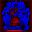

Piece: K


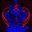

Piece: Q


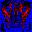

Piece: R


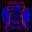

Piece: B


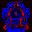

Piece: N


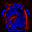

Piece: P


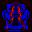

Piece: k


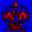

Piece: q


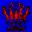

Piece: r


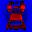

Piece: b


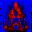

Piece: n


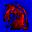

Piece: p


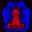

In [6]:
print "Visualization of Weights as negative(Red) to positive(Blue)"
for i in range(13):
    print "Piece: %s" % hf.labelIndex2Name(i)
    piece_weight = np.reshape(sess.run(W)[:,i], [32,32])
    hf.display_weight(piece_weight,rng=[-0.2,0.2])

Cool, you can see the shapes show up within the weights. Let's have a look at the failure cases to get a sense of what went wrong.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# sess.run(correct_prediction, feed_dict={x: test_dataset.images, y_: test_dataset.labels})
mistakes = tf.where(~correct_prediction)
mistake_indices = sess.run(mistakes, feed_dict={x: test_dataset.images,
                                                y_: test_dataset.labels}).flatten()

guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: test_dataset.images, y_: test_dataset.labels})

print "%d mistakes:" % mistake_indices.size

for idx in mistake_indices[:10]:
    a,b = test_dataset.labels[idx], guessed[idx]
    print "---"
    print "\t#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))
    print "Actual:",a
    print " Guess:",guess_prob[idx,:]
    print "---"

0 mistakes:


Some pretty blatement misses there, *more training data!* Also, lets look at several random selections, including successes.

#231 | Actual: ' ', Guessed: ' '


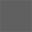

#299 | Actual: ' ', Guessed: ' '


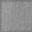

#213 | Actual: 'P', Guessed: 'P'


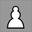

#274 | Actual: ' ', Guessed: ' '


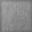

#86 | Actual: 'N', Guessed: 'N'


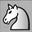

#205 | Actual: 'B', Guessed: 'B'


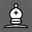

#270 | Actual: 'P', Guessed: 'P'


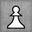

#136 | Actual: ' ', Guessed: ' '


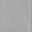

#168 | Actual: 'p', Guessed: 'p'


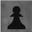

#131 | Actual: 'R', Guessed: 'R'


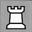

#8 | Actual: ' ', Guessed: ' '


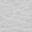

#125 | Actual: 'R', Guessed: 'R'


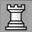

#187 | Actual: ' ', Guessed: ' '


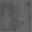

#37 | Actual: 'R', Guessed: 'R'


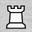

#105 | Actual: ' ', Guessed: ' '


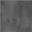

In [8]:
for idx in np.random.choice(test_dataset.num_examples,15,replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))